In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from nndl_model import *

In [3]:
# ---- sanity_sprint.py (or a single notebook cell) ----
import torch
import torch.nn as nn
import wandb

# Disable wandb logging for this quick check
# TODO setup wandb project, setup naming schema
wandb.init(project="nndl-sanity", mode="disabled")

In [4]:
# 1) Load data (uses DATA_DIR from your constants)
train_loader, val_loader, test_loader, M = make_dataloaders()

In [5]:
class TinyCNN(BaseModel):
    def __init__(self, M, lr=2e-2, feature_dim=64):
        super().__init__(M=M, lr=lr)  # 1) init base (no optimizer yet)
        self.model = nn.Sequential(  # 2) define backbone params
            nn.Conv2d(3, 32, 3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),  # -> [B, 64]
        )
        # 3) add heads + optimizer now exists
        self.configure_hierarchy(feature_dim=feature_dim)
        self.reset_optimizer()  # 4) create optimizer now that params exist

In [6]:
# 3) Instantiate model and sprint a couple epochs
model = TinyCNN(M=M, lr=2e-3, feature_dim=64)

Hyperparams: {'lr': 0.002, 'alpha': 1, 'beta': 1, 'gamma': 0.1}


In [13]:
model.__str__()

'TinyCNN(\n  (model): Sequential(\n    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))\n    (1): ReLU(inplace=True)\n    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))\n    (3): ReLU(inplace=True)\n    (4): AdaptiveAvgPool2d(output_size=1)\n    (5): Flatten(start_dim=1, end_dim=-1)\n  )\n  (criterion): CrossEntropyLoss()\n  (head_super): Linear(in_features=64, out_features=4, bias=True)\n  (head_sub): Linear(in_features=64, out_features=88, bias=True)\n)'

In [21]:
print(model.summary())

Model: name='TinyCNN_v000'
TinyCNN(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): AdaptiveAvgPool2d(output_size=1)
    (5): Flatten(start_dim=1, end_dim=-1)
  )
  (criterion): CrossEntropyLoss()
  (head_super): Linear(in_features=64, out_features=4, bias=True)
  (head_sub): Linear(in_features=64, out_features=88, bias=True)
)

Epochs trained: 0     Best Validation Loss: inf     Best Validation Accuracy: 0.0000


In [8]:
TinyCNN.name()

'TinyCNN_v000'

In [7]:
model.train_model(train_loader, val_loader, epochs=1)

Epoch 1/1 Train Loss: nan Train Acc (sup/sub): 0.0078/0.0000 Val Loss: nan Val Acc (sup/sub): 0.0000/0.0000


In [8]:
# 4) Quick inference smoke test on the test loader (no labels there)
model.eval()
with torch.no_grad():
    for imgs, img_ids in test_loader:
        logits_sup, logits_sub = model(imgs.to(model.device))
        preds_super = logits_sup.argmax(1).cpu().tolist()
        preds_sub = logits_sub.argmax(1).cpu().tolist()
        print(f"Sample predictions: super={preds_super[:5]}, sub={preds_sub[:5]}")
        break  # just peek at one batch

Sample predictions: super=[0, 0, 0, 0, 0], sub=[0, 0, 0, 0, 0]


In [9]:
x, y = next(iter(train_loader))

In [10]:
x0, y0 = train_loader.dataset[0]  # dataset *is* subscriptable

In [11]:
type(test_loader.dataset)

nndl_model.data_loaders.HierImageDataset

In [12]:
test_loader.dataset.df

,image
0,0.jpg
1,1.jpg
2,2.jpg
3,3.jpg
4,4.jpg
...,...
11175,11175.jpg
11176,11176.jpg
11177,11177.jpg
11178,11178.jpg


In [13]:
test_loader.dataset[0][0].shape

torch.Size([3, 64, 64])

In [14]:
from PIL import Image

img = Image.open(test_loader.dataset.images_dir / "0.jpg")

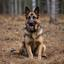

In [15]:
img

In [16]:
img.size

(64, 64)